In [1]:
import os
import pandas as pd
import numpy as np
import bisect
import pickle
import math
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# For ResNet
try:
  import timm
except:
  print('timm does not exist')
  !pip install timm
  import timm

try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

c:\Users\shavo.LAPTOP-HEST3BVP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Preprocessing & Feature Engineering
- Resize images to 64x64
- Convert to grayscale
- Normalize to range [0, 1]
- Generate HOG features

Note:
- HOG features:
    - TLDR: These features describes the image in terms of its edges direction and magnitude in a localised area of 8 x 8 pixels (see image below)
    - More detailed explanation here: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/
- Labels: {0: tops, 1: bottoms, 2: bags, 3: shoes, 4: others}
- Creates: 
    - X_train, X_test
    - X_train_hog, X_test_hog
    - y_train, y_test

In [2]:
data_paths = [os.path.join("dataset","train"), os.path.join("dataset","test")]
categories = ["tops", "bottoms", "bags", "shoes", "others"]
r1, r2 = 64, 64

X_data_train = []
X_data_train_hog = []
y_data_train = []

X_data_test = []
X_data_test_hog = []
y_data_test = []

initial_dimensions = []

for data_path in data_paths:
    for i, category in enumerate(categories):
        cat_path = os.path.join(data_path, category)
        for filename in os.listdir(cat_path):
            img_path = os.path.join(cat_path, filename)

            try:
                img = Image.open(img_path)
            except Exception as e:
                print(f"Error processing image '{img_path}': {e}")
                continue
                
            # Store initial dimensions
            initial_dimensions.append({
                'filepath': img_path,
                'category': category,
                'width': img.width,
                'height': img.height
            })

            # Resize images
            img = img.resize((r1, r2)) 

            # Convert to black and white
            img = img.convert("L")

            # Normalize pixel values (0 to 1)
            img = np.array(img) / 255.0

            ###############################
            #   Generating HOG features   #
            ###############################
            fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), visualize=False)

            if "train" in data_path:
                # Flatten image and add to X_data
                X_data_train.append(img.flatten())
                # Add corresponding label to y_data
                y_data_train.append(i)

                X_data_train_hog.append(fd)

            elif "test" in data_path:
                X_data_test.append(img.flatten())
                y_data_test.append(i)

                X_data_test_hog.append(fd)

# Convert lists to np arrays
X_train = np.array(X_data_train)
X_train_hog = np.array(X_data_train_hog)
y_train = np.array(y_data_train)
y_train_hog = np.array(y_data_train)

X_test = np.array(X_data_test)
X_test_hog = np.array(X_data_test_hog)
y_test = np.array(y_data_test)
y_test_hog = np.array(y_data_test)

initial_dimensions_df = pd.DataFrame(initial_dimensions)

### Optional: Saving the Dataframes

In [3]:
train_df = pd.DataFrame(data=X_train, columns=[f"pixel_{i}" for i in range(X_train.shape[1])])
train_df['label'] = y_train

test_df = pd.DataFrame(data=X_test, columns=[f"pixel_{i}" for i in range(X_test.shape[1])])
test_df['label'] = y_test

with open("preprocessed_data/train_df.pkl", "wb") as f:
    pickle.dump(train_df, f)

with open("preprocessed_data/test_df.pkl", "wb") as f:
    pickle.dump(test_df, f)

train_df_hog = pd.DataFrame(data=X_train_hog, columns=[f"hog_{i}" for i in range(X_train_hog.shape[1])])
train_df_hog['label'] = y_train_hog

test_df_hog = pd.DataFrame(data=X_test_hog, columns=[f"hog_{i}" for i in range(X_test_hog.shape[1])])
test_df_hog['label'] = y_test_hog

with open("preprocessed_data/hog_train_df.pkl", "wb") as f:
    pickle.dump(train_df_hog, f)

with open("preprocessed_data/hog_test_df.pkl", "wb") as f:
    pickle.dump(test_df_hog, f)

# 2. EDA

### Random sampling of images for visualisation

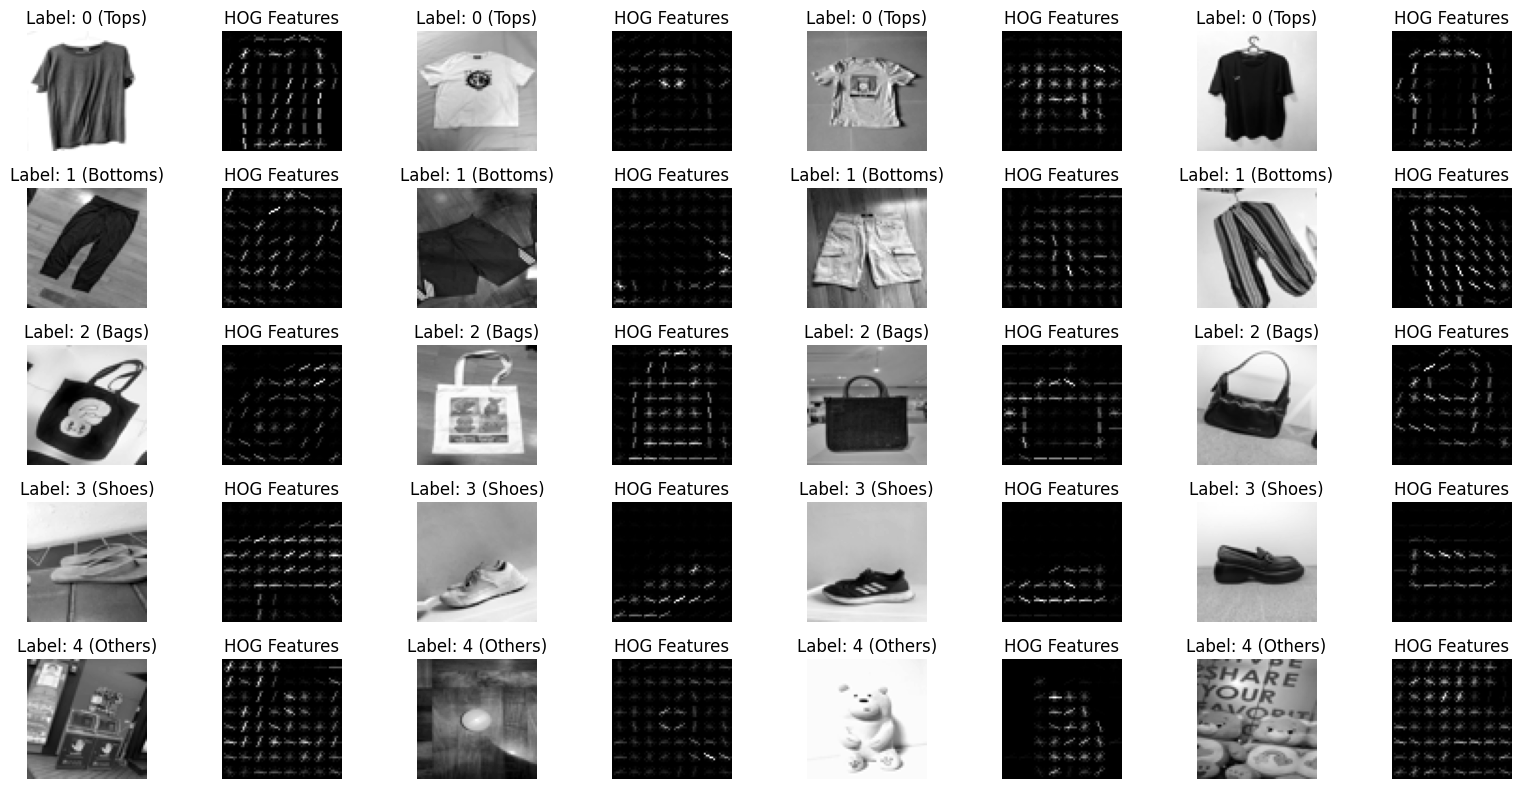

In [4]:
num_images_per_class = 4
num_classes = 5
num_images = num_images_per_class * num_classes

labels_dict = {0: "tops", 1: "bottoms", 2: "bags", 3: "shoes", 4: "others"}

# Get random indices to select images
random_indices = []
for label in range(num_classes):
    label_indices = np.where(y_train == label)[0]
    random_indices.extend(np.random.choice(label_indices, num_images_per_class, replace=False))

# Visualize the images and their HOG features
plt.figure(figsize=(16, 8), facecolor="white")
for i, idx in enumerate(random_indices):
    # Reshape the flattened pixel values back to the original image shape
    image = X_train[idx].reshape(r1, r2)
    label = y_train[idx]
    
    # Generate HOG features for the image
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
    
    # Plot the image and its HOG features
    plt.subplot(num_classes, num_images_per_class * 2, i * 2 + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label} ({labels_dict[label].capitalize()})')
    plt.axis('off')
    
    plt.subplot(num_classes, num_images_per_class * 2, i * 2 + 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Features')
    plt.axis('off')

plt.tight_layout()
plt.show()


### Image dimensions (before resizing)

In [5]:
label_map = {0: 'tops', 1: 'bottoms', 2: 'bags', 3: 'shoes', 4: 'others'}
train_df['label_name'] = train_df['label'].map(label_map)
train_df_hog['label_name'] = train_df_hog['label'].map(label_map)

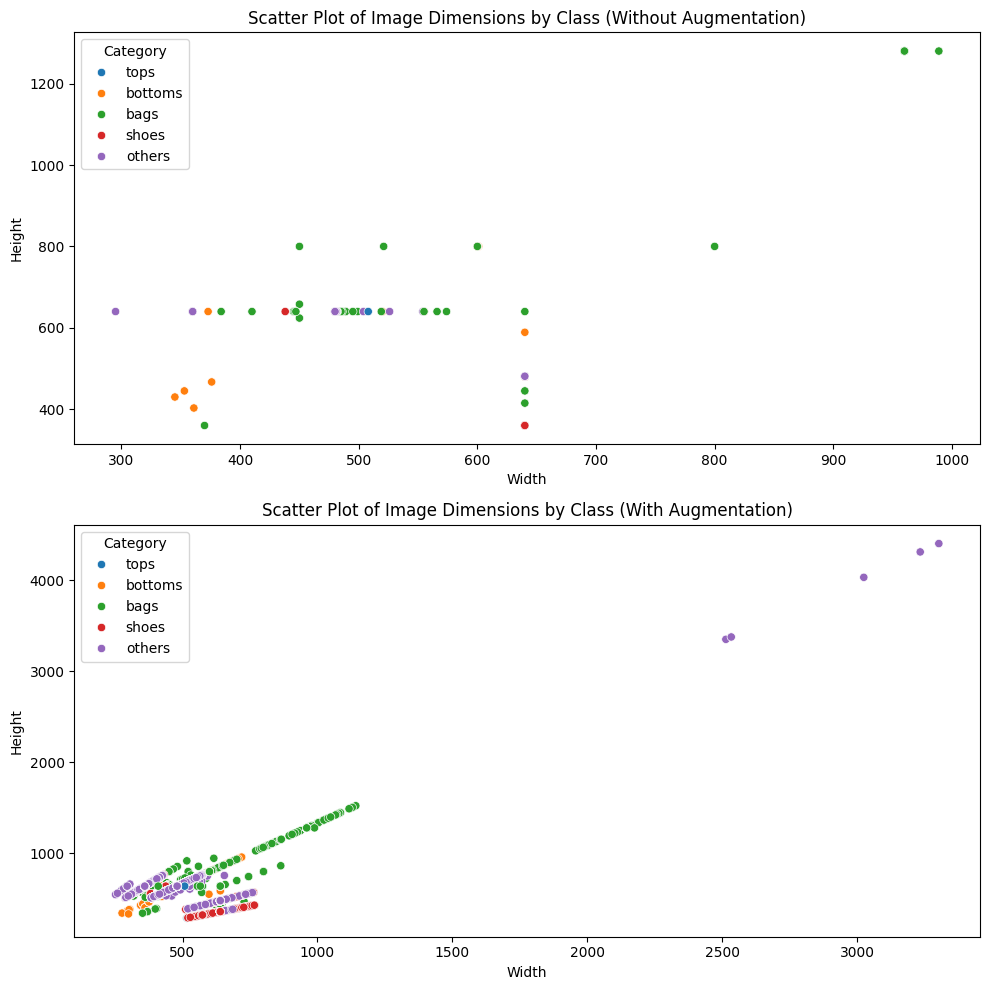

In [6]:
initial_dims_non_augmented = initial_dimensions_df[~initial_dimensions_df['filepath'].str.contains("augmented")]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Plot the first scatter plot (without augmentation) on the first subplot
sns.scatterplot(data=initial_dims_non_augmented, x='width', y='height', hue='category', palette='tab10', ax=axes[0])
axes[0].set_title('Scatter Plot of Image Dimensions by Class (Without Augmentation)')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')
axes[0].legend(title='Category', loc='upper left')

# Plot the second scatter plot (with augmentation) on the second subplot
sns.scatterplot(data=initial_dimensions_df, x='width', y='height', hue='category', palette='tab10', ax=axes[1])
axes[1].set_title('Scatter Plot of Image Dimensions by Class (With Augmentation)')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Height')
axes[1].legend(title='Category', loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

<Figure size 1200x1000 with 0 Axes>

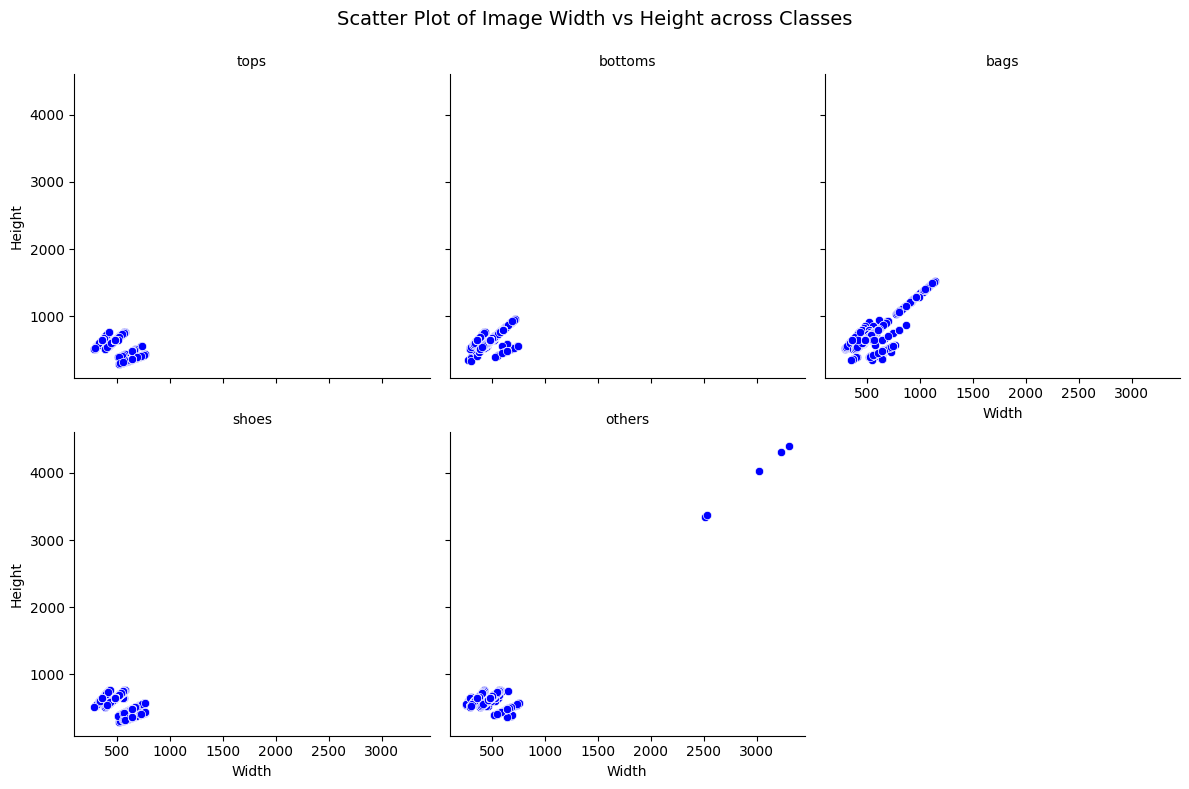

In [7]:
plt.figure(figsize=(12, 10))

# Create a FacetGrid with one scatter plot for each class
g = sns.FacetGrid(initial_dimensions_df, col='category', col_wrap=3, height=4)
g.map(sns.scatterplot, 'width', 'height', color='b', edgecolor='w')

# Set plot titles and labels
g.set_titles('{col_name}')
g.set_xlabels('Width')
g.set_ylabels('Height')

plt.suptitle('Scatter Plot of Image Width vs Height across Classes', fontsize=14)

# Adjust space between plots
plt.subplots_adjust(top=0.9)

# Show plots
plt.show()

### Class Distribution

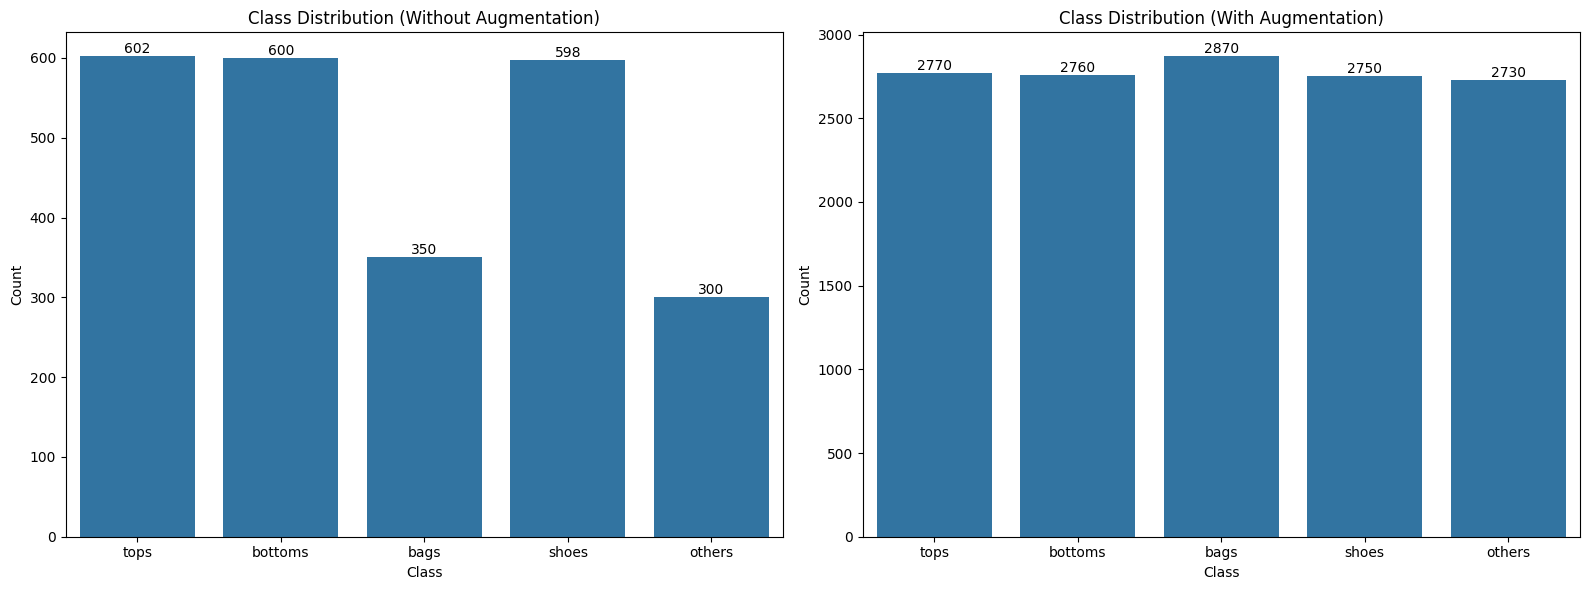

In [8]:
# Create a figure and a grid of subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the first countplot (without augmentation) on the first subplot
sns.countplot(x='category', data=initial_dims_non_augmented, ax=axes[0])
axes[0].set_title('Class Distribution (Without Augmentation)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Annotate counts on top of each bar in the first plot
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Plot the second countplot (with augmentation) on the second subplot
sns.countplot(x='category', data=initial_dimensions_df, ax=axes[1])
axes[1].set_title('Class Distribution (With Augmentation)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Annotate counts on top of each bar in the second plot
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Pixel Values Distribution

In [9]:
def plot_pixel_values(col_name, num_pixels, df):
    
    # Define pixel columns (adjust the range based on your actual columns)
    pixel_columns = [f'{col_name}_{i}' for i in range(num_pixels)]

    # Plot density distributions for each class
    plt.figure(figsize=(10, 6))

    for class_label in range(5):  # Assuming 5 classes
        # Select data for the current class
        class_data = df[df['label'] == class_label]

        # Extract pixel values for the current class
        class_pixel_values = class_data[pixel_columns].values.flatten()

        # Plot density distribution for the current class
        sns.kdeplot(class_pixel_values, label=label_map[class_label], fill=True)

    # Add title
    if col_name == 'hog':
        plt.title('Distribution of Pixel Values for Each Class (HOG features)')
    else:
        plt.title('Distribution of Pixel Values for Each Class (Grayscaled Images)')
        
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    plt.legend(title='Class')

    # Show plot
    plt.show()

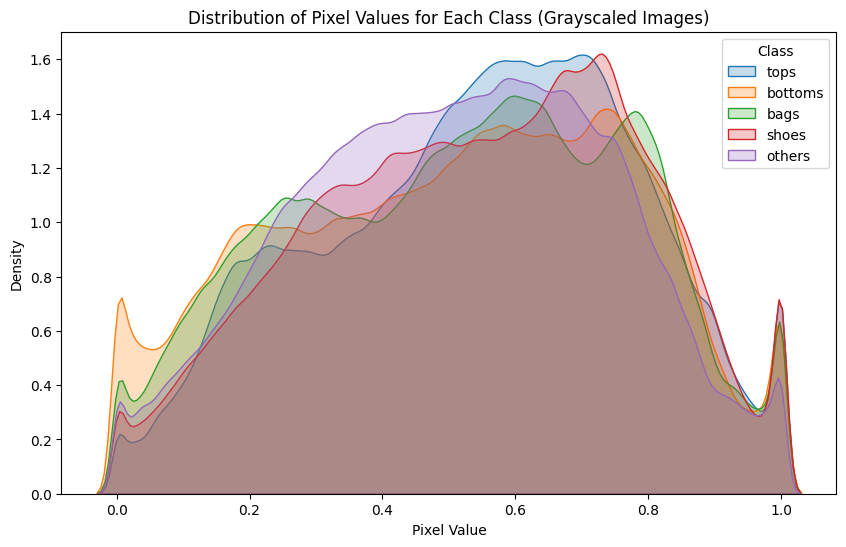

In [10]:
plot_pixel_values('pixel', 4096, train_df)

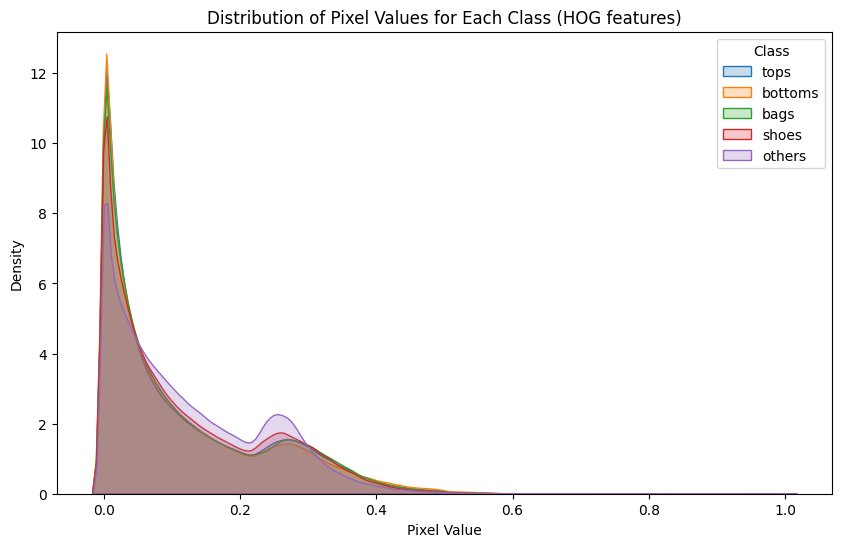

In [11]:
plot_pixel_values('hog', 1764, train_df_hog)

### Average Image

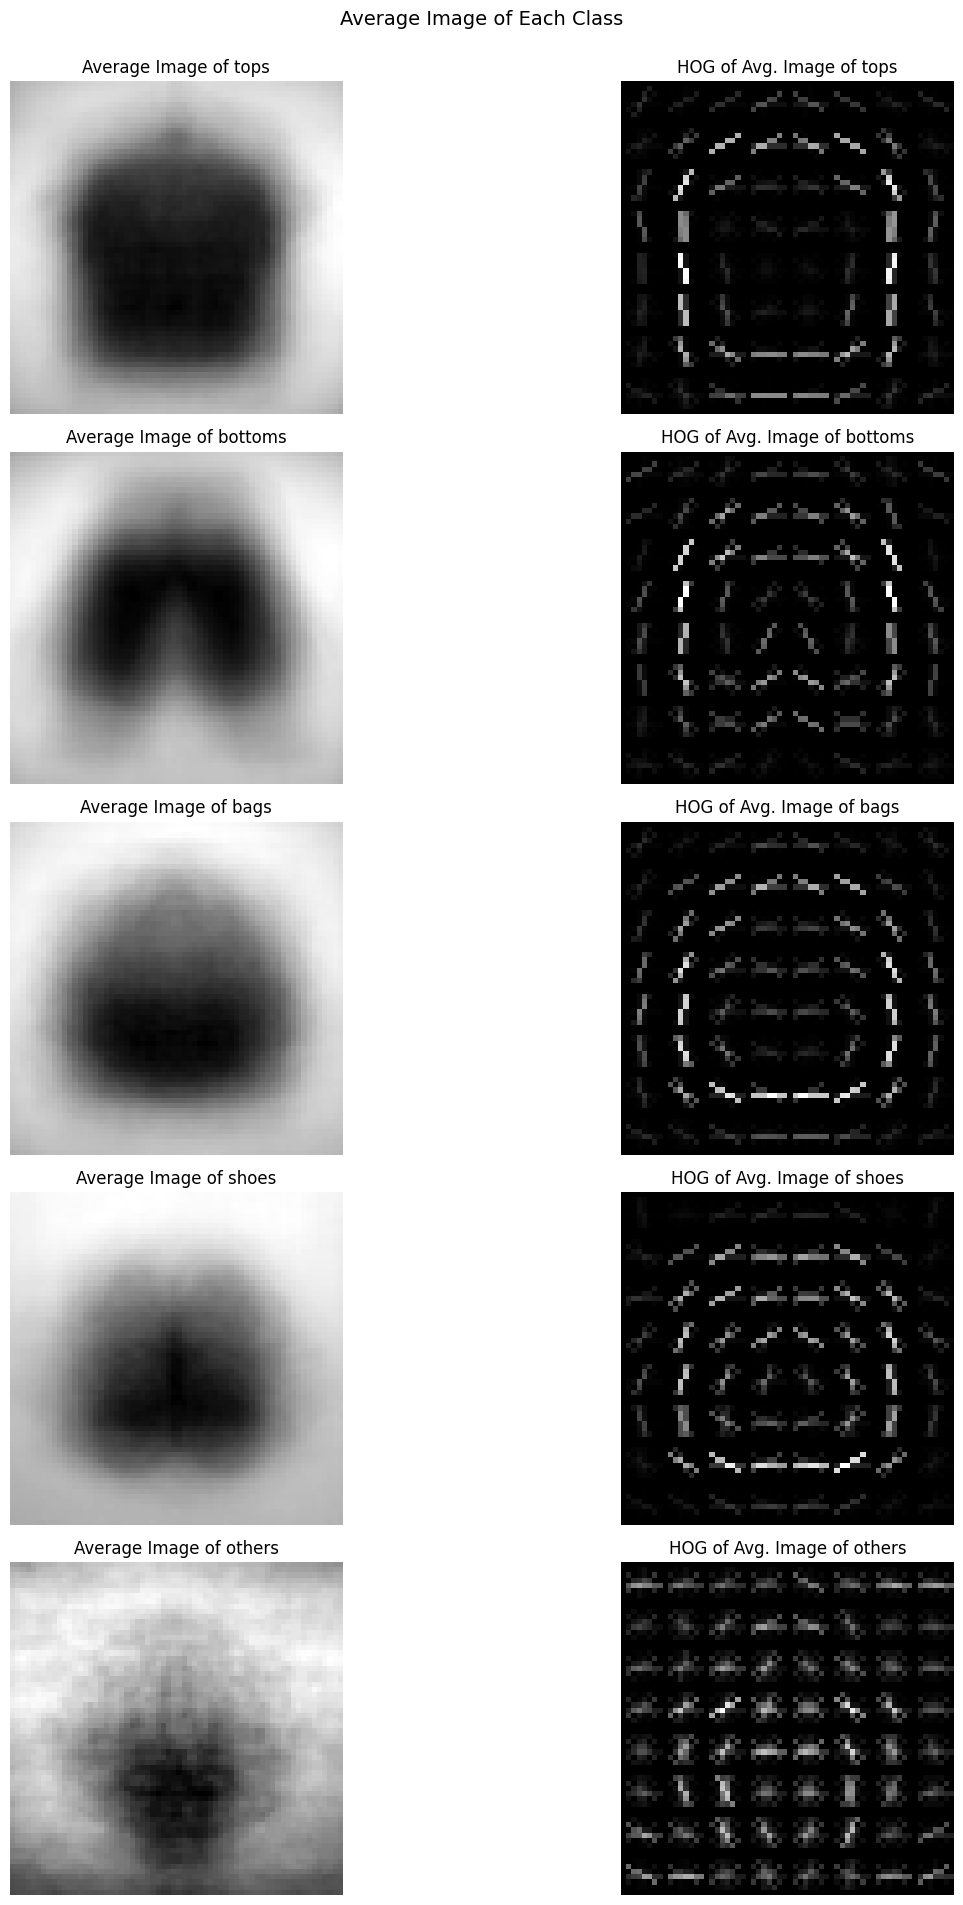

In [12]:
pixel_columns = [f'pixel_{i}' for i in range(4096)]

# Group data by the 'label' column
grouped_data = train_df.groupby('label')

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

# Iterate over each class label
for i, (label, group_df) in enumerate(grouped_data):
    # Select pixel data for the current class
    pixel_data = group_df[pixel_columns]
    
    # Compute mean pixel values for the current class
    mean_pixel_values = pixel_data.mean(axis=0)
    
    # Reshape mean pixel values array into image dimensions (assuming each image has dimensions of 64x64 pixels)
    mean_image = mean_pixel_values.values.reshape((64, 64))
    
    # Compute HOG features for the mean image
    mean_hog_features, mean_hog_image = hog(mean_image, orientations=9, pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2), visualize=True)

    # Plot the actual image on the first column
    axes[i, 0].imshow(mean_image, cmap='gray')
    axes[i, 0].set_title(f'Average Image of {label_map[label]}')  # Increase title font size
    axes[i, 0].axis('off')

    # Plot the HOG features of the mean image on the second column
    axes[i, 1].imshow(mean_hog_image, cmap='gray')
    axes[i, 1].set_title(f'HOG of Avg. Image of {label_map[label]}')  # Increase title font size
    axes[i, 1].axis('off')
    
plt.suptitle('Average Image of Each Class', fontsize=14)  # Increase overall title font size

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Show the plots
plt.show()


# Model 1: ResNet

In [4]:
class customDataset(Dataset):
    def __init__(self, X, y, r, transform=None):
        self.X = X.reshape((-1,r,r,1))
        self.y = y.reshape(-1,1)
        self.transform = transform
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]

        if self.transform:
            X = self.transform(X)
        
        return X, y
    
    def __len__(self):
        return len(self.X)

In [5]:
# Split training data into train and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.2)

# Define dataset objects
transform = transforms.Compose([transforms.ToTensor()])

r = int(math.sqrt(X_tr.shape[-1]))
ds_train = customDataset(X_tr, y_tr, r, transform=transform)
ds_val = customDataset(X_val, y_val, r, transform=transform)
ds_test = customDataset(X_test, y_test, r, transform=transform)

# Create Dataset Loaders
batch_size = 32
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

In [6]:
timm_model = timm.create_model(model_name="resnet50", pretrained=True, num_classes=5, in_chans=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [7]:
def train_step(model, dataloader, optimizer, loss_fn, accuracy_fn, device):
    
    train_loss, train_acc = 0, 0
    all_preds, all_targets, all_probs = [], [], []

    model.to(device)
    model.train()

    for i, (X, y) in enumerate(dataloader):

        # Push to device
        X, y = X.to(device), y.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Feedforward
        logits = model(X.float())
        # Compute loss
        loss = loss_fn(logits, y.long().squeeze())
        # Backpropagation
        loss.backward()
        # Update weights
        optimizer.step()

        train_loss += loss.item()
        y_preds = logits.argmax(dim=1)
        train_acc += accuracy_fn(y_preds, y.long().squeeze()).item()
        probs = F.softmax(logits, dim=1)

        all_preds += [y_preds]
        all_targets += [y.long().squeeze()]
        all_probs += [probs]

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {100* train_acc:.2f}%")
    return train_loss, train_acc, all_preds, all_targets, all_probs

def test_step(model, dataloader, loss_fn, accuracy_fn, device):

    test_loss, test_acc = 0, 0
    all_preds, all_targets, all_probs = [], [], []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X.float())
            loss = loss_fn(logits, y.long().squeeze())

            test_loss += loss.item()
            y_preds = logits.argmax(dim=1)
            test_acc += accuracy_fn(y_preds, y.long().squeeze()).item()
            probs = F.softmax(logits, dim=1)

            all_preds += [y_preds]
            all_targets += [y.long().squeeze()]
            all_probs += [probs]

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {100* test_acc:.2f}%")

    return test_loss, test_acc, all_preds, all_targets, all_probs

In [8]:
epochs = 20
best_val_loss = float("inf")
early_stopping_counter = 0
early_stopping_threshold = 5

for epoch in range(epochs):
    print("-"*50 + f" Current epoch: {epoch + 1} " + "-"*50)
    train_loss, train_acc, train_preds, train_targets, train_probs = train_step(
        model=timm_model,
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    val_loss, val_acc, val_preds, val_targets, val_probs = test_step(
        model=timm_model,
        dataloader=val_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(timm_model.state_dict(), "models/resnet_best_model.pth")  # Save the best model
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_threshold:
            print("Early Stopping Triggered")
            break

-------------------------------------------------- Current epoch: 1 --------------------------------------------------
Train loss: 0.39875 | Train accuracy: 85.47%
Test loss: 0.11249 | Test accuracy: 96.29%
-------------------------------------------------- Current epoch: 2 --------------------------------------------------
Train loss: 0.07098 | Train accuracy: 97.69%
Test loss: 0.05589 | Test accuracy: 98.47%
-------------------------------------------------- Current epoch: 3 --------------------------------------------------
Train loss: 0.04666 | Train accuracy: 98.52%
Test loss: 0.04485 | Test accuracy: 98.36%
-------------------------------------------------- Current epoch: 4 --------------------------------------------------
Train loss: 0.02622 | Train accuracy: 99.10%
Test loss: 0.05465 | Test accuracy: 98.11%
-------------------------------------------------- Current epoch: 5 --------------------------------------------------
Train loss: 0.03521 | Train accuracy: 98.95%
Test los

# ResNet Evaluation
Test Results using Best ResNet Model

In [9]:
model_path = "models/resnet_best_model.pth"
timm_model = timm.create_model(model_name="resnet50", num_classes=5, in_chans=1)
timm_model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(timm_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=5).to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

test_loss, test_acc, test_preds, test_targets, test_probs = test_step(
        model=timm_model,
        dataloader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

Test loss: 0.11685 | Test accuracy: 96.67%


Results for Resnet (without HOG) on test set:
Accuracy: 0.9673469387755103
Precision: 0.963591476091476
Recall: 0.9542857142857143
F1 Score: 0.9576188740486172


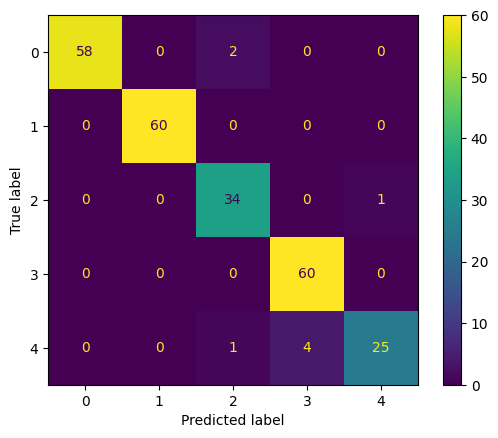

In [10]:
test_preds_list = [pred.item() for batch_preds in test_preds for pred in batch_preds]
test_targets_list = [target.item() for batch_targets in test_targets for target in batch_targets]
test_probs_list = []
for batch_probs in test_probs:
    for prob in batch_probs:
        test_probs_list.append(prob.tolist())

# 1. Accuracy, Precision, Recall, F1 score
accuracy_resnet = accuracy_score(test_targets_list, test_preds_list)
precision_resnet = precision_score(test_targets_list, test_preds_list, average='macro')
recall_resnet = recall_score(test_targets_list, test_preds_list, average='macro')
f1_resnet = f1_score(test_targets_list, test_preds_list, average='macro')

print("Results for Resnet (without HOG) on test set:")
print(f"Accuracy: {accuracy_resnet}")
print(f"Precision: {precision_resnet}")
print(f"Recall: {recall_resnet}")
print(f"F1 Score: {f1_resnet}")

# 2. Confusion Matrix
resnet_cm = confusion_matrix(test_targets_list, test_preds_list)
ConfusionMatrixDisplay(confusion_matrix=resnet_cm).plot()

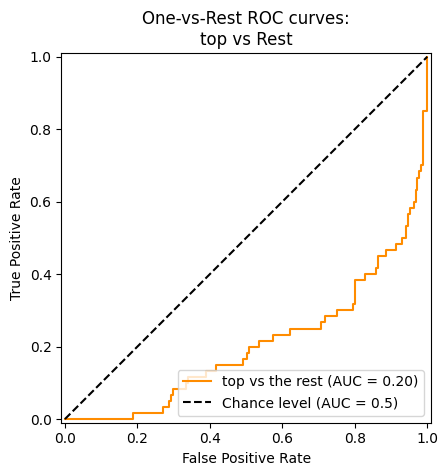

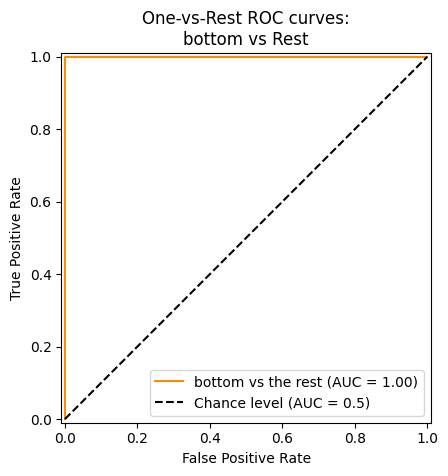

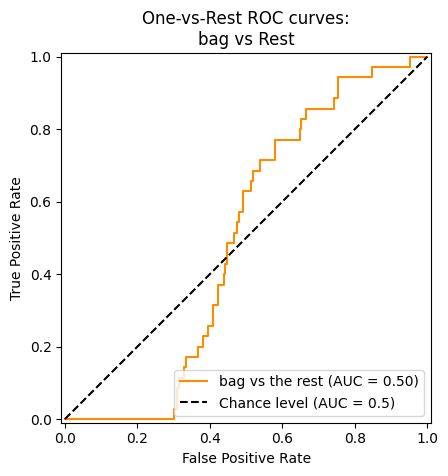

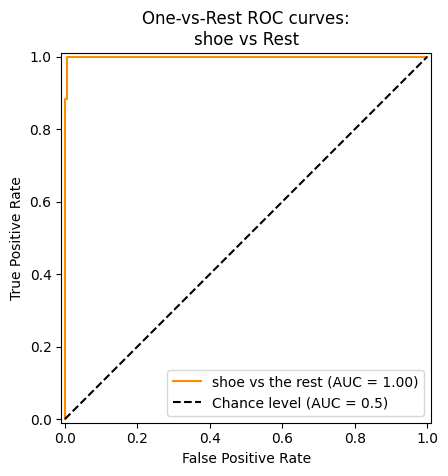

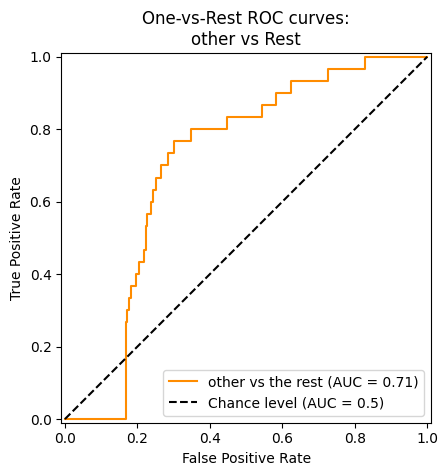

In [11]:
# 3. One vs Rest ROC curve

categories = ["top", "bottom", "bag", "shoe", "other"]
train_targets_list = [target.item() for batch_targets in train_targets for target in batch_targets]
y_train_str = [categories[label] for label in train_targets_list]
y_test_str = [categories[label] for label in test_targets_list]
y_score_arr = np.array(test_probs_list)

label_binarizer = LabelBinarizer().fit(y_train_str)
y_onehot_test = label_binarizer.transform(y_test_str)
y_onehot_test.shape  # (n_samples, n_classes)

for cat in categories:
    class_id = np.flatnonzero(label_binarizer.classes_ == cat)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score_arr[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",
    plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest",
    )

# Model 2: KNN

## KNN (without HOG Features)

In [28]:
# Creating splits
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

In [29]:
# Testing on validation set
knn = KNeighborsClassifier()

knn.fit(X_tr, y_tr)

# Predict
y_val_pred_knn = knn.predict(X_val)

# Print results
print("Accuracy for KNN model (without HOG) on validation set:"+str(accuracy_score(y_val, y_val_pred_knn)))

Accuracy for KNN model (without HOG) on validation set:0.6725339200586725


Results for KNN (without HOG) on test set:
Accuracy: 0.6857142857142857
Precision: 0.6685241196637077
Recall: 0.6357142857142857
F1 Score: 0.640367131359075


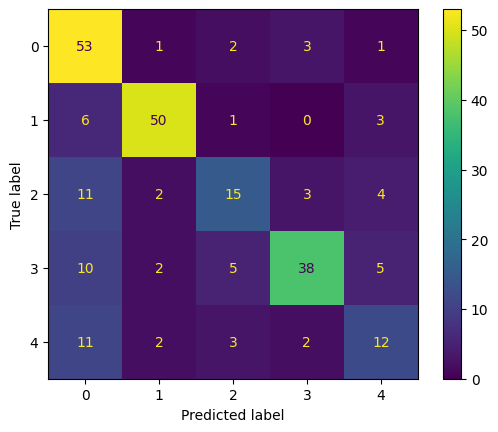

In [30]:
# Testing on test set
y_pred_knn = knn.predict(X_test)

# Print results
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='macro')
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

print("Results for KNN (without HOG) on test set:")
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn).plot()

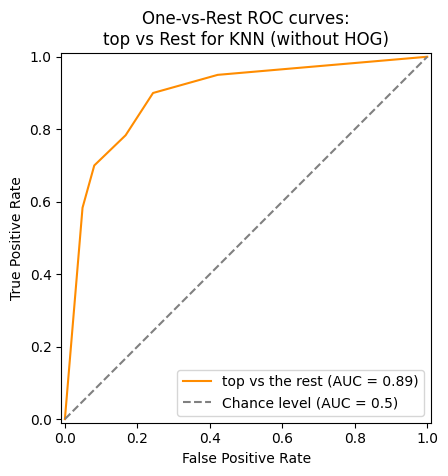

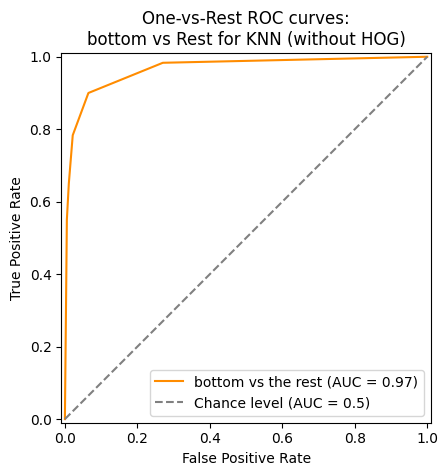

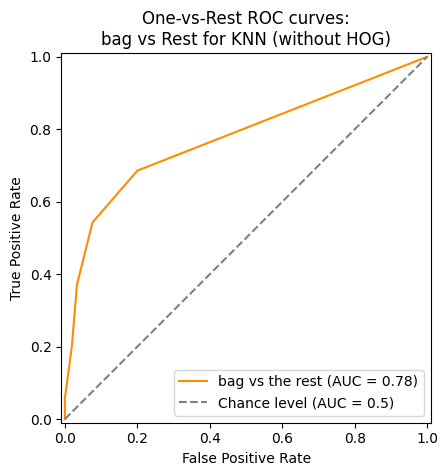

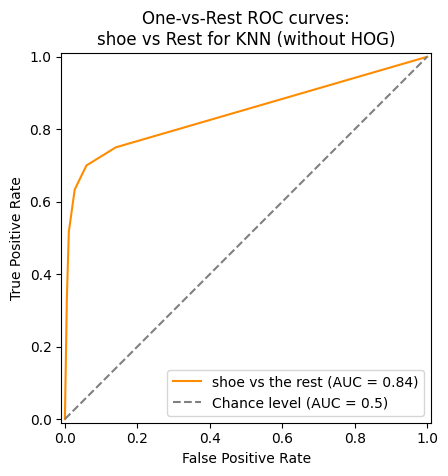

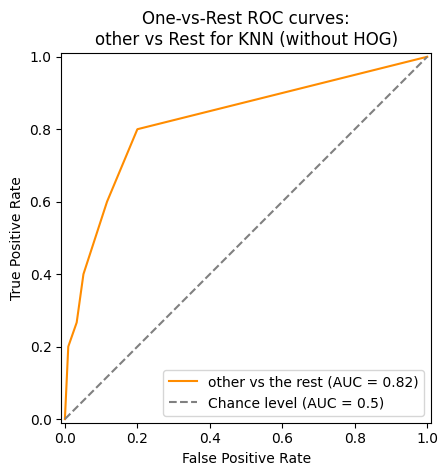

In [31]:
# Plot AUC curves for each category
y_score = knn.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_tr)
y_onehot_test = label_binarizer.transform(y_test)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for KNN (without HOG)",
    )

## KNN (with HOG Features)

In [32]:
X_tr_hog, X_val_hog, y_tr_hog, y_val_hog = train_test_split(X_train_hog, y_train_hog, random_state=42, test_size=0.2)

In [33]:
# Testing on validation set
knn_hog = KNeighborsClassifier()

knn_hog.fit(X_tr_hog, y_tr_hog)

# Predict
y_val_pred_hog_knn = knn_hog.predict(X_val_hog)

# Print results
print("Accuracy for KNN model (with HOG) on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog_knn)))

Accuracy for KNN model (with HOG) on validation set: 0.8760542720938761


Results for KNN (with HOG) on test set:
Accuracy: 0.9020408163265307
Precision: 0.8941573243030405
Recall: 0.8980952380952381
F1 Score: 0.8948449993937455


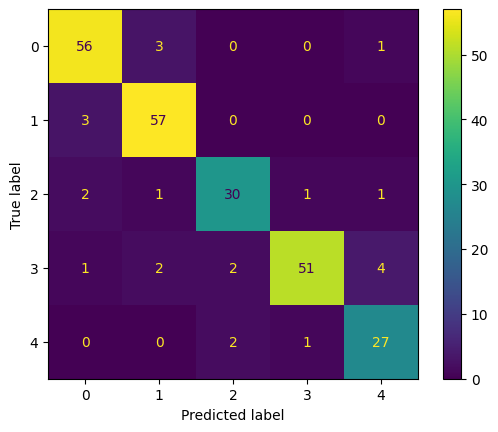

In [34]:
# Testing on test set
y_pred_hog_knn = knn_hog.predict(X_test_hog)

# Print results
accuracy_knn_hog = accuracy_score(y_test_hog, y_pred_hog_knn)
precision_knn_hog = precision_score(y_test_hog, y_pred_hog_knn, average='macro')
recall_knn_hog = recall_score(y_test_hog, y_pred_hog_knn, average='macro')
f1_knn_hog = f1_score(y_test_hog, y_pred_hog_knn, average='macro')
conf_matrix_knn_hog = confusion_matrix(y_test_hog, y_pred_hog_knn)

print("Results for KNN (with HOG) on test set:")
print(f"Accuracy: {accuracy_knn_hog}")
print(f"Precision: {precision_knn_hog}")
print(f"Recall: {recall_knn_hog}")
print(f"F1 Score: {f1_knn_hog}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn_hog).plot()

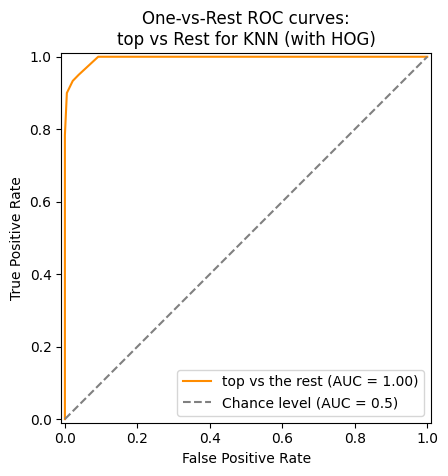

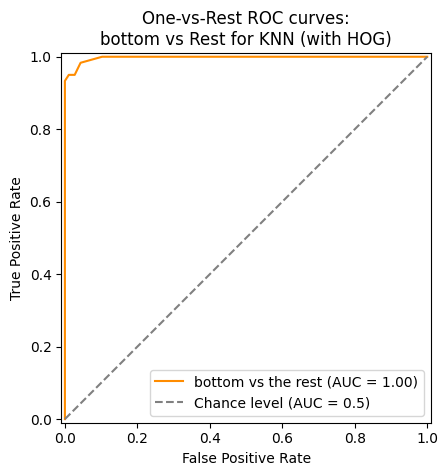

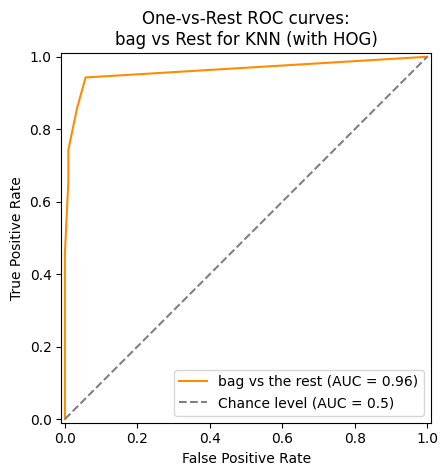

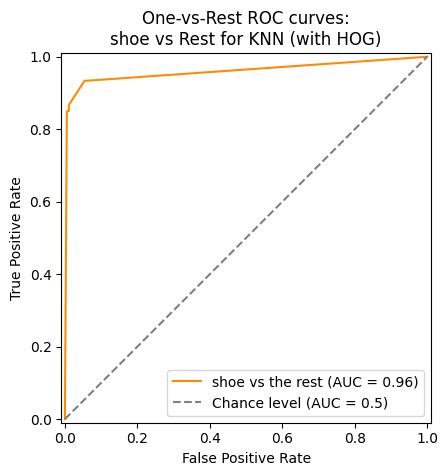

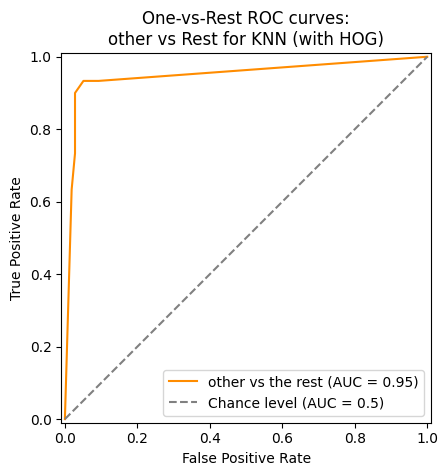

In [35]:
# Plot AUC curves for each category
y_score = knn_hog.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for KNN (with HOG)",
    )

### Tuning Hyperparameters

In [36]:
# Print default parameters
print("Current params: ", knn_hog.get_params())

Current params:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [37]:
random_grid = { 'n_neighbors' : [1,3,5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

model = KNeighborsClassifier()

# Use random search to find the best hyperparameters
knn_rand_search = RandomizedSearchCV(
    estimator = model,
    param_distributions = random_grid,
    n_iter = 8,
    cv = 5,
)

knn_rand_search.fit(X_tr_hog, y_tr_hog)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=8,
                   param_distributions={'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': [1, 3, 5, 7, 9, 11, 13,
                                                        15],
                                        'weights': ['uniform', 'distance']})

In [38]:
# Shows the most optimal hyperparameter value
knn_rand_search.best_params_

{'weights': 'distance', 'n_neighbors': 1, 'metric': 'manhattan'}

In [39]:
# Use the most optimal parameters for the model 
knn_tuned = knn_rand_search.best_estimator_
knn_tuned.fit(X_tr_hog, y_tr_hog)

KNeighborsClassifier(metric='manhattan', n_neighbors=1, weights='distance')

In [40]:
# Testing tuned model on validation set
y_val_pred_hog = knn_tuned.predict(X_val_hog)

# Print results
print("Accuracy for tuned KNN on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog)))

Accuracy for tuned KNN on validation set: 0.944994499449945


Results for tuned KNN on test set:
Accuracy: 0.9142857142857143
Precision: 0.9014121863799284
Recall: 0.8890476190476191
F1 Score: 0.8937627953513431


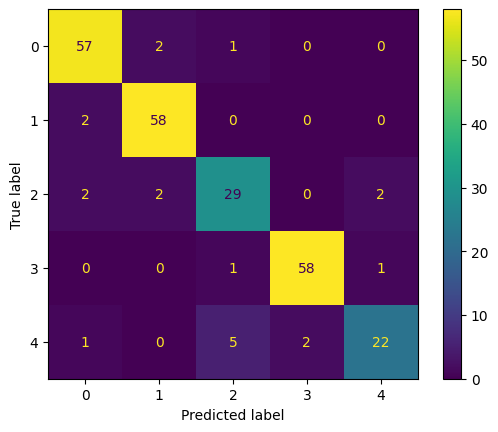

In [41]:
# Testing tuned model on test set
y_pred_hog = knn_tuned.predict(X_test_hog)

# Print results
accuracy_tuned_knn = accuracy_score(y_test_hog, y_pred_hog)
precision_tuned_knn = precision_score(y_test_hog, y_pred_hog, average='macro')
recall_tuned_knn = recall_score(y_test_hog, y_pred_hog, average='macro')
f1_tuned_knn = f1_score(y_test_hog, y_pred_hog, average='macro')
conf_matrix_tuned_knn = confusion_matrix(y_test_hog, y_pred_hog)

print("Results for tuned KNN on test set:")
print(f"Accuracy: {accuracy_tuned_knn}")
print(f"Precision: {precision_tuned_knn}")
print(f"Recall: {recall_tuned_knn}")
print(f"F1 Score: {f1_tuned_knn}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned_knn).plot()

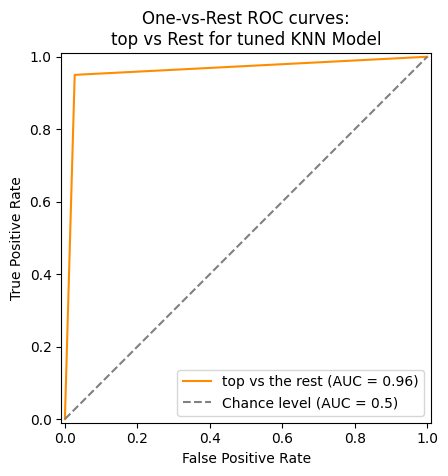

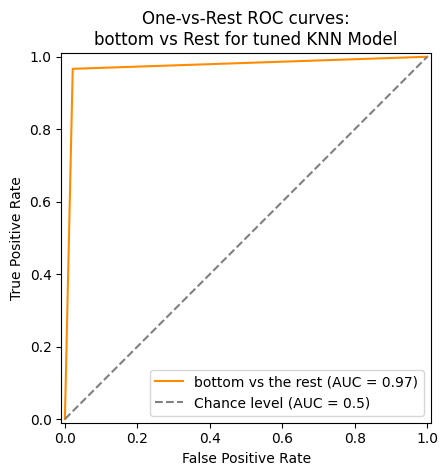

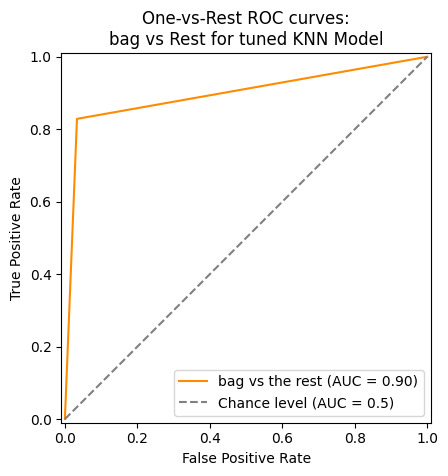

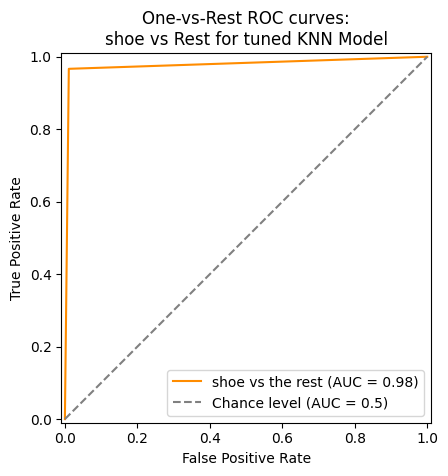

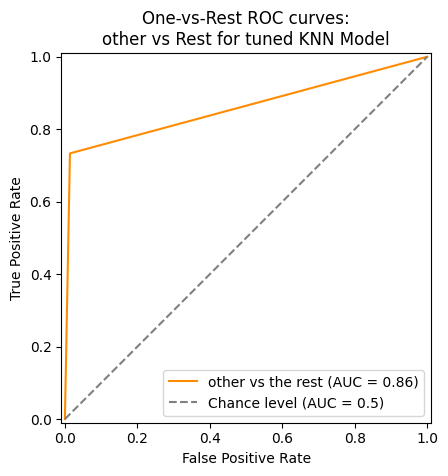

In [42]:
# Plot AUC curves for each category for tuned model
y_score = knn_tuned.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for tuned KNN Model",
    )

In [43]:
# Metrics comparison before and after tuning 
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'KNN (without HOG)': [accuracy_knn, precision_knn, 
                            recall_knn, f1_knn],
    'KNN (with HOG)': [accuracy_knn_hog, precision_knn_hog, 
                            recall_knn_hog, f1_knn_hog],
    'KNN after tuning (with HOG)': [accuracy_tuned_knn, precision_tuned_knn, 
                      recall_tuned_knn, f1_tuned_knn]
})

metrics

,Metric,KNN (without HOG),KNN (with HOG),KNN after tuning (with HOG)
0,Accuracy,0.685714,0.902041,0.914286
1,Precision,0.668524,0.894157,0.901412
2,Recall,0.635714,0.898095,0.889048
3,F1 Score,0.640367,0.894845,0.893763


# Model 3: SVM

## SVM (without HOG Features)

In [9]:
# Creating splits
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

In [10]:
# Testing on validation set
svm = SVC(probability=True)

svm.fit(X_tr, y_tr)

# Predict
y_val_pred_svm = svm.predict(X_val)

# Print results
print("Accuracy for SVM model (without HOG) on validation set:"+str(accuracy_score(y_val, y_val_pred_svm)))

Accuracy for SVM model (without HOG) on validation set:0.7227722772277227


Results for SVM (without HOG) on test set:
Accuracy: 0.7306122448979592
Precision: 0.6993828427983043
Recall: 0.6947619047619049
F1 Score: 0.6935264826026436


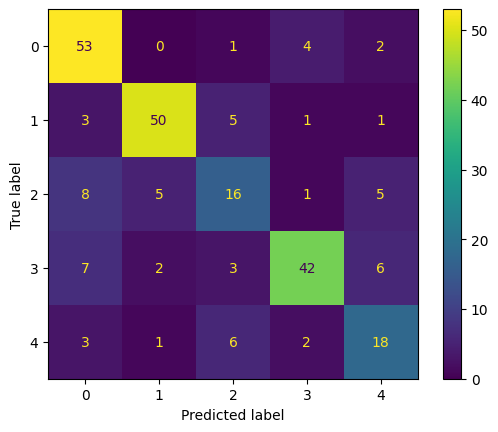

In [11]:
# Testing on test set
y_pred_svm = svm.predict(X_test)

# Print results
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("Results for SVM (without HOG) on test set:")
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1 Score: {f1_svm}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm).plot()

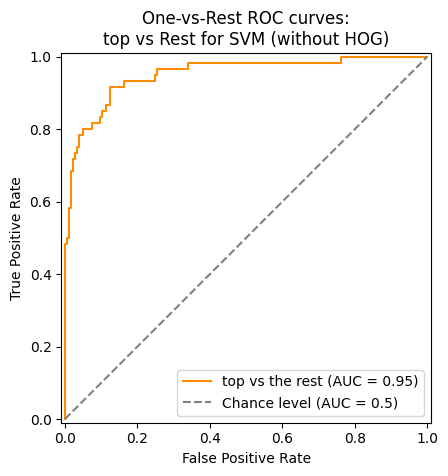

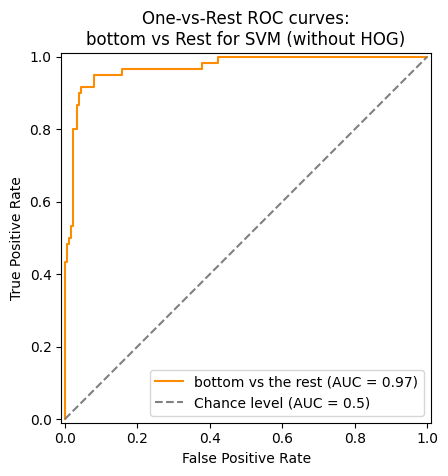

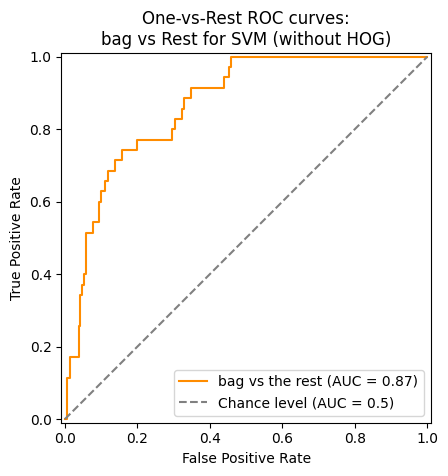

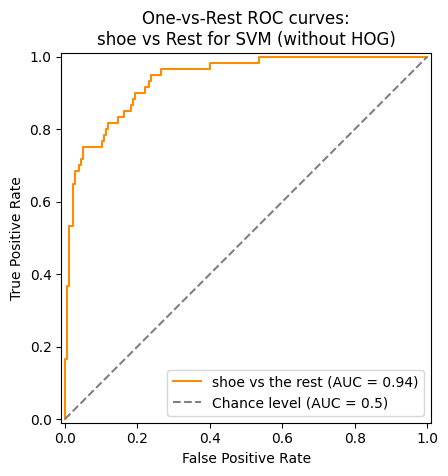

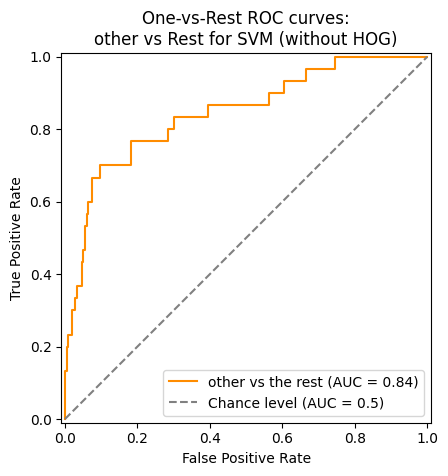

In [12]:
# Plot AUC curves for each category
y_score = svm.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_tr)
y_onehot_test = label_binarizer.transform(y_test)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for SVM (without HOG)",
    )

## SVM (with HOG Features)

In [16]:
X_tr_hog, X_val_hog, y_tr_hog, y_val_hog = train_test_split(X_train_hog, y_train_hog, random_state=42, test_size=0.2)

In [17]:
# Testing on validation set
svm_hog = SVC(probability=True)

svm_hog.fit(X_tr_hog, y_tr_hog)

# Predict
y_val_pred_hog_svm = svm_hog.predict(X_val_hog)

# Print results
print("Accuracy for SVM model (with HOG) on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog_svm)))

Accuracy for SVM model (with HOG) on validation set: 0.9083241657499084


Results for KNN (with HOG) on test set:
Accuracy: 0.8979591836734694
Precision: 0.8883307210031347
Recall: 0.881904761904762
F1 Score: 0.8787700346954017


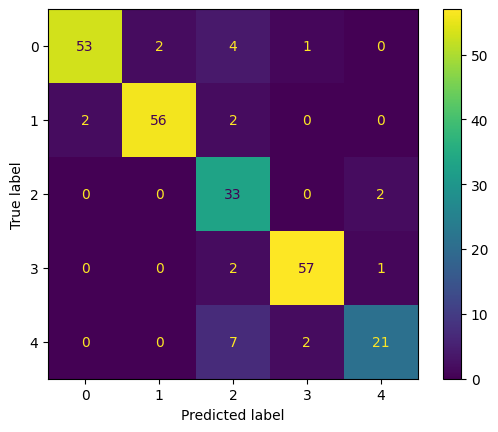

In [18]:
# Testing on test set
y_pred_hog_svm = svm_hog.predict(X_test_hog)

# Print results
accuracy_svm_hog = accuracy_score(y_test_hog, y_pred_hog_svm)
precision_svm_hog = precision_score(y_test_hog, y_pred_hog_svm, average='macro')
recall_svm_hog = recall_score(y_test_hog, y_pred_hog_svm, average='macro')
f1_svm_hog = f1_score(y_test_hog, y_pred_hog_svm, average='macro')
conf_matrix_svm_hog = confusion_matrix(y_test_hog, y_pred_hog_svm)

print("Results for KNN (with HOG) on test set:")
print(f"Accuracy: {accuracy_svm_hog}")
print(f"Precision: {precision_svm_hog}")
print(f"Recall: {recall_svm_hog}")
print(f"F1 Score: {f1_svm_hog}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm_hog).plot()

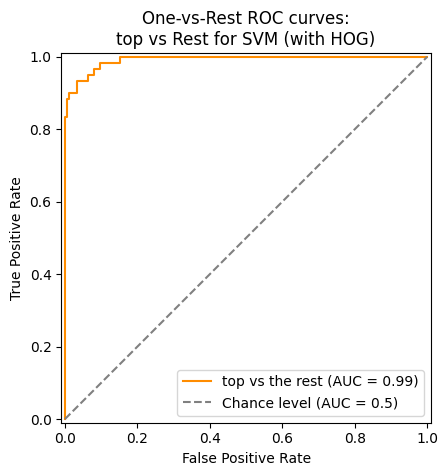

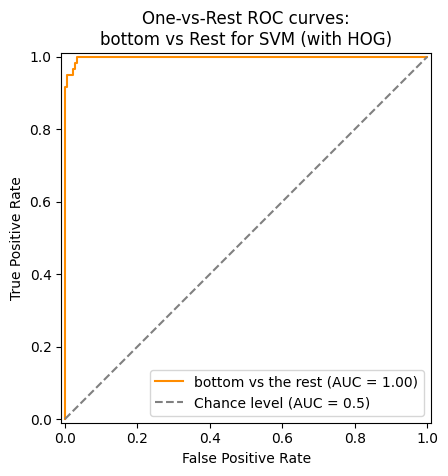

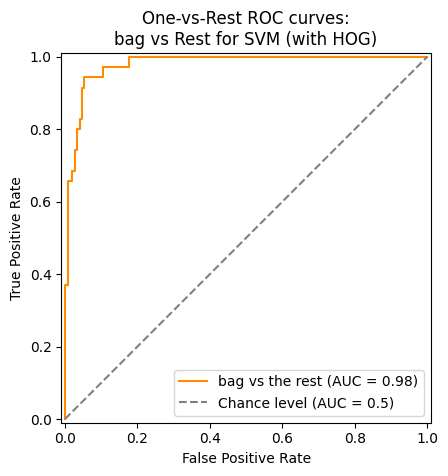

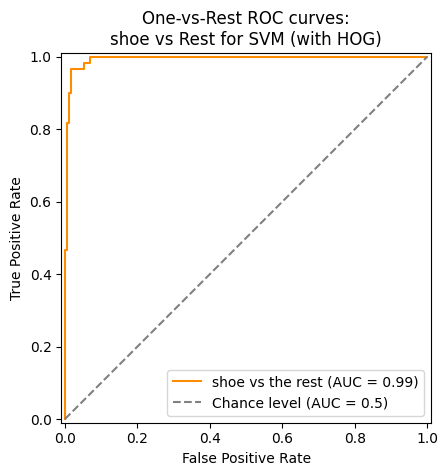

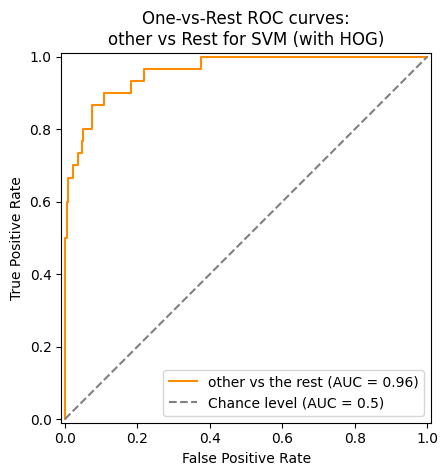

In [19]:
# Plot AUC curves for each category
y_score = svm_hog.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for SVM (with HOG)",
    )

### Tuning Hyperparamters

In [20]:
# Print default parameters
print("Current params: ", svm_hog.get_params())

Current params:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': ["auto", "scale"], 
              'kernel': ['rbf'], 
             }  
  
svm_rand_grid = RandomizedSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
svm_rand_grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(svm_rand_grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(svm_rand_grid.best_estimator_) 

# Best parameters for SVM is the same as original SVM 

In [25]:
# Use the most optimal parameters for the model 
svm_tuned = SVC(C=1, gamma="scale", probability=True)
svm_tuned.fit(X_tr_hog, y_tr_hog)

SVC(C=1, probability=True)

In [26]:
# Testing tuned model on validation set
y_val_pred_hog = svm_tuned.predict(X_val_hog)

# Print results
print("Accuracy for tuned SVM on validation set: "+str(accuracy_score(y_val_hog, y_val_pred_hog)))

Accuracy for tuned SVM on validation set: 0.9083241657499084


Results for tuned KNN on test set:
Accuracy: 0.8979591836734694
Precision: 0.8883307210031347
Recall: 0.881904761904762
F1 Score: 0.8787700346954017


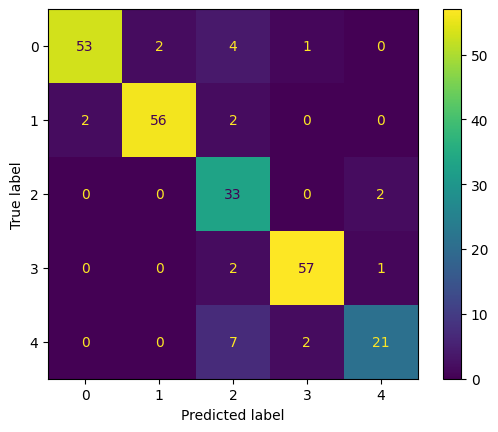

In [27]:
# Testing tuned model on test set
y_pred_hog = svm_tuned.predict(X_test_hog)

# Print results
accuracy_tuned_svm = accuracy_score(y_test_hog, y_pred_hog)
precision_tuned_svm = precision_score(y_test_hog, y_pred_hog, average='macro')
recall_tuned_svm = recall_score(y_test_hog, y_pred_hog, average='macro')
f1_tuned_svm = f1_score(y_test_hog, y_pred_hog, average='macro')
conf_matrix_tuned_svm = confusion_matrix(y_test_hog, y_pred_hog)

print("Results for tuned KNN on test set:")
print(f"Accuracy: {accuracy_tuned_svm}")
print(f"Precision: {precision_tuned_svm}")
print(f"Recall: {recall_tuned_svm}")
print(f"F1 Score: {f1_tuned_svm}")
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_tuned_svm).plot()

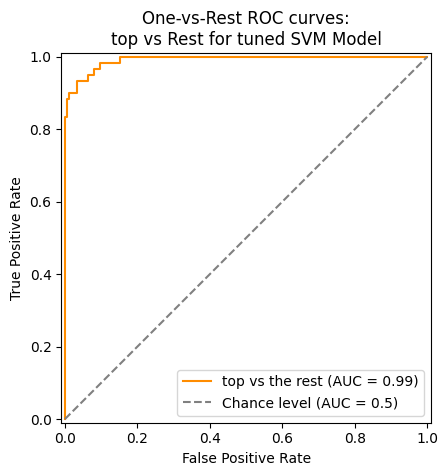

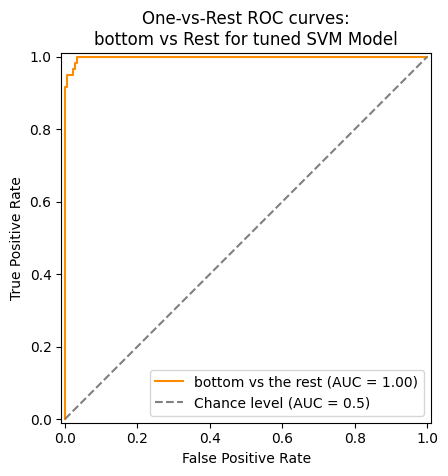

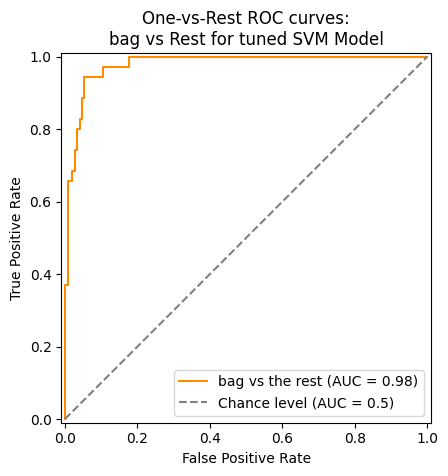

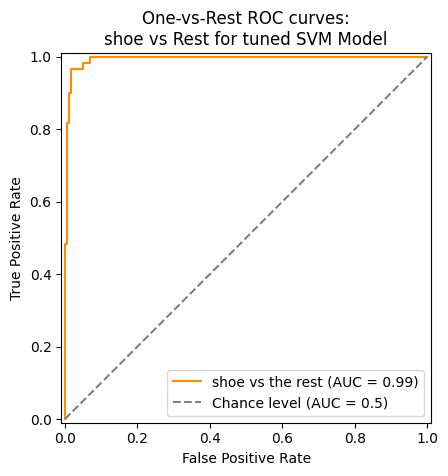

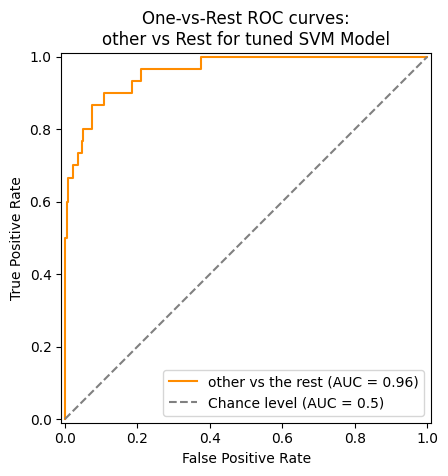

In [28]:
# Plot AUC curves for each category for tuned model
y_score = svm_tuned.predict_proba(X_test_hog)
label_binarizer = LabelBinarizer().fit(y_tr_hog)
y_onehot_test = label_binarizer.transform(y_test_hog)

categories = ["top", "bottom", "bag", "shoe", "other"]
for i, cat in enumerate(categories):
    class_id = np.flatnonzero(label_binarizer.classes_ == i)[0]
    display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{cat} vs the rest",
    color="darkorange",    
    )
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance level (AUC = 0.5)')
    plt.legend()
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"One-vs-Rest ROC curves:\n{cat} vs Rest for tuned SVM Model",
    )